### Workplace Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import nltk
from nltk.corpus import stopwords
!pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Nmf
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from operator import itemgetter

!pip install bitermplus
!pip install tmplot
import bitermplus as btm
import tmplot as tmp
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')


from nltk.stem.wordnet import WordNetLemmatizer
import spacy

from pprint import pprint
!pip install little-mallet-wrapper
import little_mallet_wrapper as lmw

stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm') 
nlp.disable_pipes('ner', 'parser')

     |████████████████████████████████| 24.1 MB 8.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 614 kB 31.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.10-cp37-cp37m-linux_x86_64.whl size=931270 sha256=0f8f012736d72a261725fea92adca1f5cd8ac4450d0404c03ba2219859fb1c69
  Stored in directory: /root/.cache/pip/wheels/2b/1a/8d/58328971ebe27f346b2e0c05ea9fe45bc67986310557074141
Successfully built bitermplus
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.3 MB 13.5 MB/s 
  Created wheel for tmplot: filename=tmplot-0.0.5-py3-none-any.whl size=13967 sha256=e72b9d9c39c3f476237756a5c519

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f8b881e31a0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f8b881e3280>)]

### Part 1: Import, Clean, and Preprocess Data

In [4]:
bey = pd.read_csv('beyonce-discography.csv')

In [5]:
bey.head(2)

song  year                                             lyrics
0     Summertime  2003  out of all the guys that approached me walkin ...
1  My First Time  2003  verse 1  all in all you ve been there for me y...

In [8]:
# Shion's code, removing any punctuation and changing to lower case 

bey['lyrics'] = \
bey['lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
bey['lyrics'] = \
bey['lyrics'].map(lambda x: x.lower())
bey['lyrics'].head()

dataset = bey.lyrics.values.tolist() 

In [18]:
# this is from the reading course, defining the functions used to clean the text 

stop_words = stopwords.words('english')

def sent_to_words(sentences): 
    '''
    creates list of words and removes punctuation
    '''
    for sentence in sentences: 
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(lyrics):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in lyrics]

def lemmatization(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyrics_clean = []
    for sent in lyrics:
        doc = nlp(" ".join(sent)) 
        lyrics_clean.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return lyrics_clean

In [19]:
# applying the functions 

words = list(sent_to_words(dataset))
wordsnostops = remove_stopwords(words)
lyrics_lemmatized = lemmatization(wordsnostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [23]:
print(lyrics_lemmatized[0])

['guy', 'approach', 'walkin', 'know', 'stay', 'aside', 'wait', 'take', 'time', 'know', 'impress', 'fourth', 'day', 'look', 'eye', 'see', 'refrain', 'want', 'man', 'need', 'friend', 'friend', 'talk', 'really', 'listen', 'touch', 'hand', 'hand', 'get', 'bright', 'bright', 'trusting', 'close', 'eye', 'feel', 'love', 'begin', 'summertime', 'fall', 'love', 'summertime', 'shine', 'summertime', 'baby', 'summertime', 'summertime', 'verse', 'beyonca', 'year', 'close', 'fall', 'love', 'hold', 'know', 'set', 'grow', 'old', 'wit', 'fill', 'son', 'little', 'girl', 'together', 'raise', 'family', 'refrain', 'want', 'man', 'need', 'friend', 'good', 'friend', 'talk', 'really', 'listen', 'touched', 'hand', 'get', 'bright', 'bright', 'trusting', 'close', 'eye', 'feel', 'love', 'begin', 'summertime', 'fall', 'love', 'summertime', 'shine', 'summertime', 'baby', 'summertime', 'summertime', 'verse', 'go', 'cruise', 'world', 'pearl', 'gator', 'boot', 'girl', 'summertime', 'linen', 'fresh', 'fruit', 'let', 'go

### Part 2 Exploratory Data Analysis 
see secondary file for code

### Part 3.1 Testing Different Models: LDA
https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

In [24]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

coherences: [0.4002195622572747, 0.3890308980217315, 0.3479225091056102, 0.3219453038693142, 0.3262206753530762, 0.3157226999092934, 0.32211085008106893, 0.330668334881316, 0.32398988763455405, 0.3247431720849766, 0.32251791844347805, 0.30508494014318716, 0.32632044228977997, 0.31748178299027047, 0.34454577504433165, 0.3569878372926182, 0.3257194944425318, 0.3851597474391518]
perplexities: [-6.397258846588122, -6.325600442541124, -6.2782585389584975, -6.244614117377103, -6.234305636480346, -6.195331954142809, -6.188607781734393, -6.196735649662967, -6.136204499542001, -6.149717154227007, -6.1362446362771905, -6.133263385001054, -6.149703916648596, -6.122356686525518, -6.104390854660226, -6.105424782985754, -6.101874550984994, -6.09918356115001]


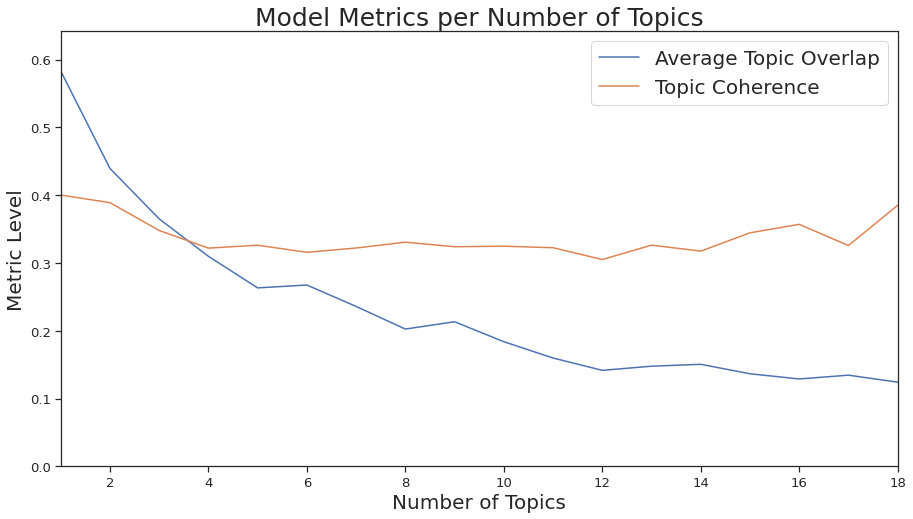

In [30]:
def topic_num_lda(id2word, bow_corpus):
  '''
  function to find optimal topic number for lda model
  '''
  # Considering 1-20 topics, dataset is relatively small so this shouldn't take very long 
  num_topics = list(range(20)[1:])
  num_keywords = 15

  LDA_models = {}
  LDA_topics = {}
  for i in num_topics:
      LDA_models[i] = LdaModel(corpus=bow_corpus,
                              id2word=id2word,
                              num_topics=i,
                              update_every=1,
                              chunksize=len(bow_corpus),
                              passes=20,
                              alpha='auto')

      shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
  LDA_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      LDA_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

  coherences = [CoherenceModel(model=LDA_models[i], texts=lyrics_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]


  perplexities = [LDA_models[i].log_perplexity(bow_corpus) for i in num_topics[:-1]]

  print('coherences:', coherences)
  print('perplexities:', perplexities)

  plt.figure(figsize=(15,8))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()   

#run function
id2word = corpora.Dictionary(lyrics_lemmatized)
bow_corpus = [id2word.doc2bow(lyrics) for lyrics in lyrics_lemmatized]
topic_num_lda(id2word, bow_corpus)

### Part 3.2 Testing Different Models: NMF 
https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

In [95]:
def topic_num_nmf(id2word, bow_corpus):

  num_topics = list(range(20)[1:])
  num_keywords = 20

  nmf_models = {}
  nmf_topics = {}
  for i in num_topics:
      nmf_models[i] = Nmf(
          corpus=bow_corpus,
          num_topics=i,
          id2word=id2word,
          chunksize=2000,
          passes=5,
          kappa=.1,
          minimum_probability=0.01,
          w_max_iter=300,
          w_stop_condition=0.0001,
          h_max_iter=100,
          h_stop_condition=0.001,
          eval_every=10,
          normalize=True
      )

      shown_topics = nmf_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      nmf_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

  nmf_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(nmf_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(nmf_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      nmf_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(nmf_stability[i]).mean() for i in num_topics[:-1]]

  coherences = [CoherenceModel(model=nmf_models[i], texts=lyrics_lemmatized, dictionary=id2word, coherence='c_v').get_coherence() for i in num_topics[:-1]]

  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics)-1)] 
  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  print('ideal_topic_num (when maxing divergence):', ideal_topic_num)
  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)

  plt.figure(figsize=(20,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()  

ideal_topic_num (when maxing divergence): 18
mean_stabilities: [0.5476190476190476, 0.39262065095398424, 0.35733028684483464, 0.28929830240338644, 0.2544821791283001, 0.23252954321778724, 0.21771346815957848, 0.2002659687754792, 0.1868360509095848, 0.17842251622166885, 0.171261072274431, 0.1769399804068283, 0.17711532091063292, 0.17489610186591875, 0.17089253704159427, 0.16112627899202223, 0.15867395377592522, 0.15269400709074546]
coherences: [0.37025834208802977, 0.3381303245362271, 0.34024551401130926, 0.35946226420515975, 0.33622483087223526, 0.37788571478253935, 0.35965533011670947, 0.34393660087642164, 0.333459725950437, 0.3508243632401968, 0.3411138380614972, 0.35812093508759846, 0.3394518496930441, 0.35648996928039256, 0.3401101341983165, 0.3405057875544323, 0.3544260425189005, 0.3570639596614196]


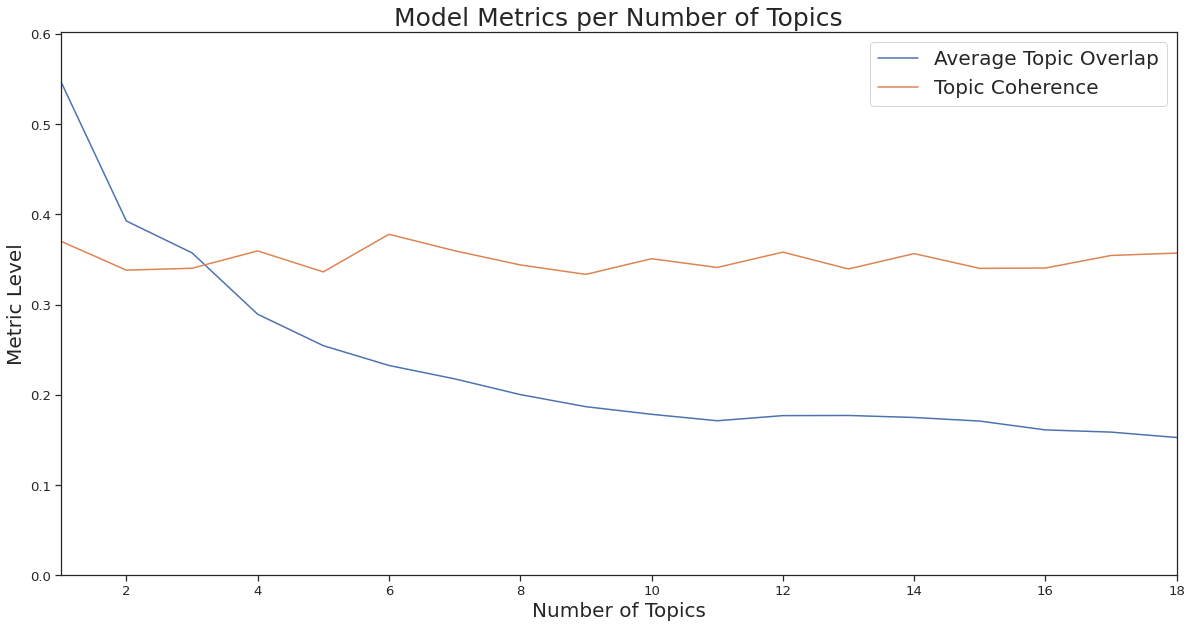

In [96]:

id2word = corpora.Dictionary(lyrics_lemmatized)

id2word.filter_extremes(no_below=10, no_above=0.80, keep_n=5000)

bow_corpus = [id2word.doc2bow(lyrics) for lyrics in lyrics_lemmatized]

topic_num_nmf(id2word, bow_corpus)

In [78]:
texts = bey['lyrics'].str.strip().tolist()

In [79]:
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [89]:
# INITIALIZING AND RUNNING MODEL
model = btm.BTM(
    X, vocabulary, seed=12321, T=4, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=20)
p_zd = model.transform(docs_vec)

100%|██████████| 86/86 [00:00<00:00, 4221.10it/s]


In [90]:
# METRICS
perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
coherence = btm.coherence(model.matrix_topics_words_, X, M=20)

print(perplexity)
print(coherence)

1.740063128533053e-175
[-161.20512951  -68.23848721  -64.83744414  -85.16486751]


In [91]:
tmp.report(model=model, docs=texts)

### Part 3.3 Testing Different Models: BTM 

100%|██████████| 86/86 [00:00<00:00, 4416.89it/s]


mean_stabilities: [0.5833333333333333, 0.37521323070522156, 0.31670566876708, 0.2586896120704217, 0.2562037738542907, 0.2550731807717645, 0.229707276534192, 0.21463861583028973, 0.2078468114150273, 0.18366629020483313, 0.16322255686867637, 0.1441960118756336, 0.1406956156917353, 0.13860417848750417, 0.13374928756024393, 0.1329860200229437, 0.1292158826722814, 0.12832444095067022]
coherences: [-121.72461103037925, -181.21970906837154, -176.94439149899122, -200.30618668320895, -192.56626827496194, -202.13080259487904, -192.4607845303135, -193.61508688179993, -204.0434223990248, -208.00314863152067, -198.71992623400902, -195.2062985199005, -197.10634137808296, -192.09731671637266, -195.88144442833308, -203.5153194837732, -204.1043632242789, -199.06006386342358]
perplexities: [463.5495976259273, 411.99858167552935, 364.4663938990233, 345.22482979954754, 318.36864961842684, 304.68128399148037, 282.6201731241781, 272.81055705647543, 267.55520960165103, 249.52024689585343, 243.5476968315901, 

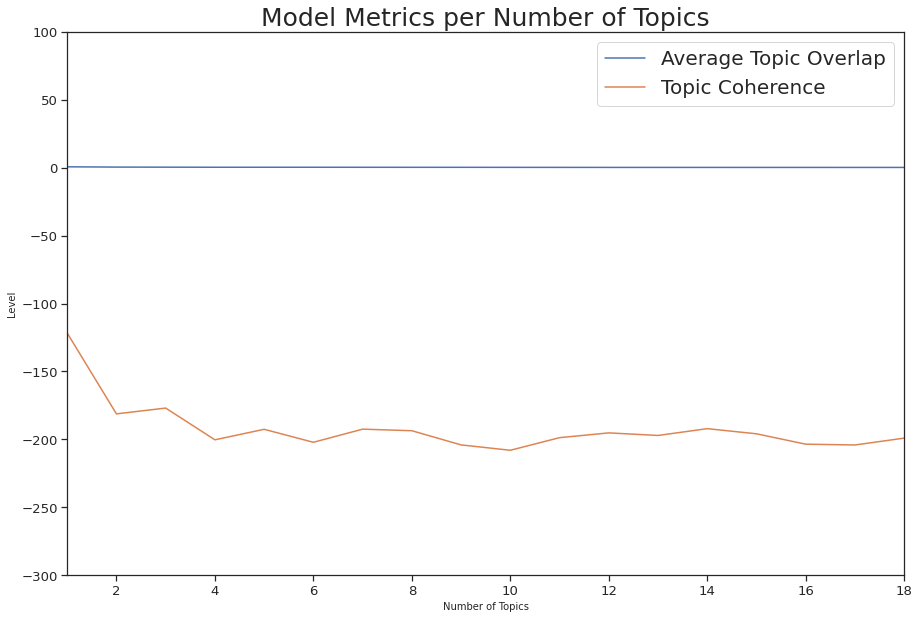

In [40]:
def topic_num_btm(texts, stop_words):
  '''
  function to find optimal topic number for btm model
  '''
  
  num_topics = list(range(20)[1:])
  num_keywords = 15

  X, vocabulary, vocab_dict = btm.get_words_freqs(lyrics, stop_words=stop_words)
  docs_vec = btm.get_vectorized_docs(lyrics, vocabulary)
  biterms = btm.get_biterms(docs_vec)

  btm_models = {}
  btm_topics = {}
  for i in num_topics:
      btm_models[i] = btm.BTM(X, vocabulary, seed=45000, T=i, M=20, alpha=40/8, beta=0.01)
      btm_models[i].fit(biterms, iterations=20)

      p_zd = btm_models[i].transform(docs_vec)

      top_words = btm.get_top_topic_words(btm_models[i],words_num=num_keywords)
      btm_topics[i] = top_words.T.values.tolist()

  btm_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(btm_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(btm_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      btm_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(btm_stability[i]).mean() for i in num_topics[:-1]]
  
  coherences = [np.mean(btm_models[i].coherence_) for i in num_topics[:-1]]

  perplexities = [btm_models[i].perplexity_ for i in num_topics[:-1]]

  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)
  print('perplexities:', perplexities)

  plt.figure(figsize=(15,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  ax.set_ylim([-300, 100])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Level', fontsize=10)
  ax.set_xlabel('Number of Topics', fontsize=10)
  plt.legend(fontsize=20)
  plt.show()   

#run function
lyrics = [' '.join(i) for i in lyrics_lemmatized]
topic_num_btm(lyrics, stop_words=None)

### Part 4 Subsetting Data and Implementing LDA


In [70]:
# Define the LDA Function

def try_lda(corpus, id2word, num_topics): 
  lda_model = gensim.models.ldamodel.LdaModel(
      corpus=corpus,    
      id2word=id2word,  
      num_topics=num_topics,    
      random_state=150, 
      update_every=1,   
      chunksize=100,    
      passes=10,        
      alpha='auto',      
      per_word_topics=True 
      
  )
 
  for j, (topic_num, prop_topic) in enumerate(lda_model.print_topics()):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    print('Topic', topic_num, ':', topic_keywords)

In [55]:
# subset data into eras of interest 

print(bey)
bey_prelem = bey[bey['year'] <= 2016]
bey_postlem = bey[bey['year'] > 2016]

             song  year                                             lyrics
0      Summertime  2003  out of all the guys that approached me walkin ...
1   My First Time  2003  verse 1  all in all you ve been there for me y...
2   Crazy in Love  2003  intro  jay z   beyoncã©  yes   whoo  ow   so c...
3    Naughty Girl  2003  i love to love you  baby i love to love you  b...
4        Baby Boy  2003  intro  sean paul  certified quality a dat di g...
..            ...   ...                                                ...
81      otherside  2020  verse 1  beyoncã©  if the storm comes if we bu...
82       my power  2020  chorus  nija   beyoncã©  they ll never take my...
83           scar  2020  verse 1  070 shake  i wonder how and why it we...
84   black parade  2020  verse 1  i m goin  back to the south i m goin ...
85         spirit  2020  intro  uishi kwa muda mrefu mfalme  uishi kwa ...

[86 rows x 3 columns]


In [60]:
# clean and preprocess prelemonade data 
bey_prelem.head(2)

song  year                                             lyrics
0     Summertime  2003  out of all the guys that approached me walkin ...
1  My First Time  2003  verse 1  all in all you ve been there for me y...

In [68]:
bey_prelem['lyrics'] = \
bey_prelem['lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
bey_prelem['lyrics'] = \
bey_prelem['lyrics'].map(lambda x: x.lower())
bey_prelem['lyrics'].head()

dataset2 = bey_prelem.lyrics.values.tolist() 

In [69]:
# apply the functions for lda onto the pre-lemonade dataset 

words = list(sent_to_words(dataset2))
wordsnostops = remove_stopwords(words)
prelemlyrics_lemmatized = lemmatization(wordsnostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [75]:
# obtain topic solution for pre-lemonade lyrics 

id2word = corpora.Dictionary(prelemlyrics_lemmatized)
lyrics = prelemlyrics_lemmatized 
corpus = [id2word.doc2bow(lyrics) for lyrics in prelemlyrics_lemmatized] #term doc frequency 

for i in [3, 4]: 
  print('LDA topic model for', i,)
  try_lda(corpus, id2word, i)
  print('\n')

LDA topic model for 3
Topic 0 : love, time, let, say, get, know, check, chorus, take, baby
Topic 1 : get, love, baby, know, look, let, bad, crazy, good, want
Topic 2 : go, let, get, know, see, love, feel, light, baby, want


LDA topic model for 4
Topic 0 : love, say, time, let, check, know, baby, take, boy, want
Topic 1 : get, let, love, look, know, baby, crazy, want, see, upgrade
Topic 2 : go, let, get, see, know, love, time, body, verse, chorus
Topic 3 : go, get, bad, baby, love, know, bone, cause, feel, chorus




In [72]:
# repeat the steps above with post-lemonade data 
bey_postlem.head(2)


song  year                                             lyrics
59  pray you catch me  2019  you can taste the dishonesty it s all over you...
60            hold up  2019  chorus  hold up  they don t love you like i lo...

In [73]:
bey_postlem['lyrics'] = \
bey_postlem['lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
bey_postlem['lyrics'] = \
bey_postlem['lyrics'].map(lambda x: x.lower())
bey_postlem['lyrics'].head()

dataset3 = bey_postlem.lyrics.values.tolist()

In [74]:
words = list(sent_to_words(dataset3))
wordsnostops = remove_stopwords(words)
postlemlyrics_lemmatized = lemmatization(wordsnostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [77]:
# obtain topic solution for post-lemonade lyrics 

id2word = corpora.Dictionary(postlemlyrics_lemmatized)
lyrics = postlemlyrics_lemmatized 
corpus = [id2word.doc2bow(lyrics) for lyrics in postlemlyrics_lemmatized] #term doc frequency 

for i in [3, 4]: 
  print('LDA topic model for', i,)
  try_lda(corpus, id2word, i)
  print('\n')

LDA topic model for 3
Topic 0 : way, back, find, baby, make, go, time, daddy, catch, verse
Topic 1 : already, love, know, big, get, say, skin, way, never, time
Topic 2 : go, daddy, watch, say, get, forever, tell, slay, ever, let


LDA topic model for 4
Topic 0 : back, way, find, baby, go, time, make, daddy, use, life
Topic 1 : already, love, know, big, get, say, skin, way, never, come
Topic 2 : daddy, say, slay, let, come, money, tell, go, work, shoot
Topic 3 : go, watch, promise, forever, ever, get, jealousy, mood, verse, catch


